In [63]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
df = pd.read_csv('/Users/zachkeskinen/Documents/infrasound/data/literature/attenuation_low_f.csv', names = ['paper','freq','drop','density','attcoef','attcon','drop2'])
df = df.drop(['drop','drop2','attcon'], axis = 1)
df.loc[:,'paper'] = df.paper.fillna(method = 'ffill')
df = df.drop(df.loc[df.freq == 'frequency band (kHz)', :].index, axis = 0)
df = df.drop(0)
for col in df.columns:
    try:
        df[col] = df[col].astype(float)
    except:
        pass
df = df[df.freq < 10001]

In [64]:
with open('/Users/zachkeskinen/Documents/infrasound/data/literature/attcoef.pkl', 'rb') as f:
    ourres = pickle.load(f)
ourres = ourres[ourres.index < 50]

In [86]:
sns.set(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': 'grey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.grid.axis':'y',
 'axes.labelcolor': 'black',
 'axes.linewidth': 1,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'lightgrey',
 'figure.figsize': (18, 12),
 'grid.color': 'grey',
 'grid.alpha':1,
 'grid.linewidth':0.5,
 'image.aspect':'auto',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'savefig.dpi':300,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'grey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'grey',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.color':'grey',
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":26,
                                "axes.labelsize":16})

Text(0.5, 1.0, 'Literature Attenuation Coefficent vs Frequency')

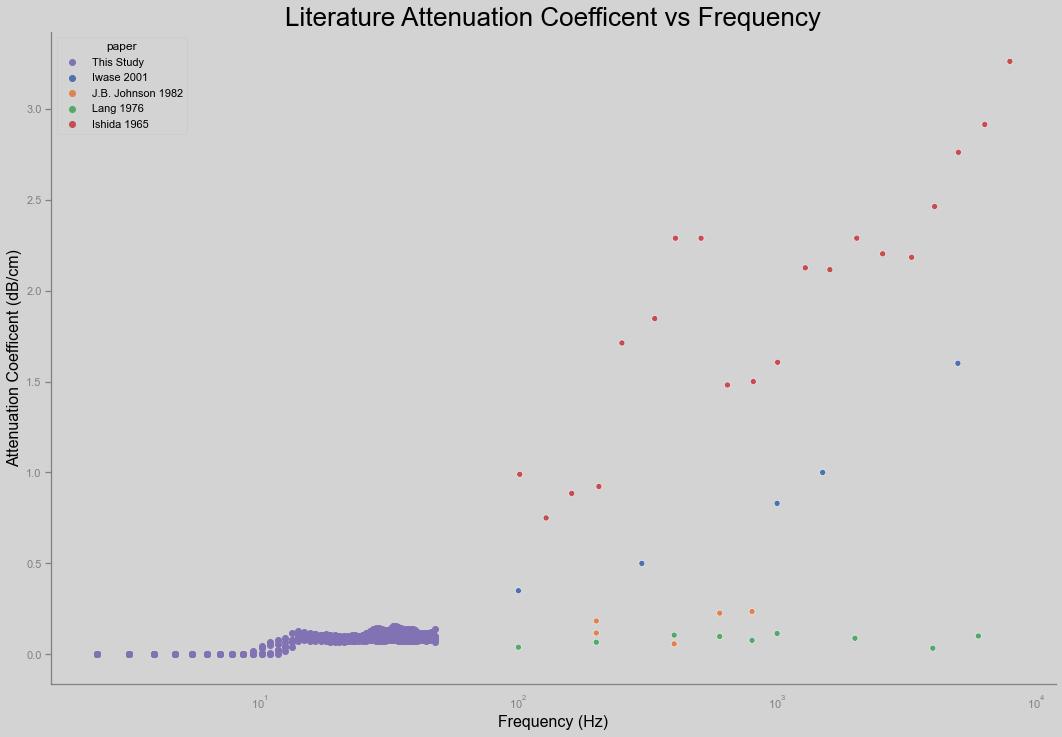

In [115]:
f, ax = plt.subplots()
for i, col in enumerate(ourres.columns):
    if i == 0:
        ax.scatter(ourres.index, ourres[col], color = 'C4', label = 'This Study')
    else:
        ax.scatter(ourres.index, ourres[col], color = 'C4')
sns.scatterplot(x = 'freq', y = 'attcoef', hue = 'paper', data = df, ax = ax)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.title('Literature Attenuation Coefficent vs Frequency')

In [93]:
with open('/Users/zachkeskinen/Documents/infrasound/data/literature/attcoef_mean.pkl', 'rb') as f:
    ourmean = pickle.load(f)
ourmean = ourmean[ourmean.index < 50]

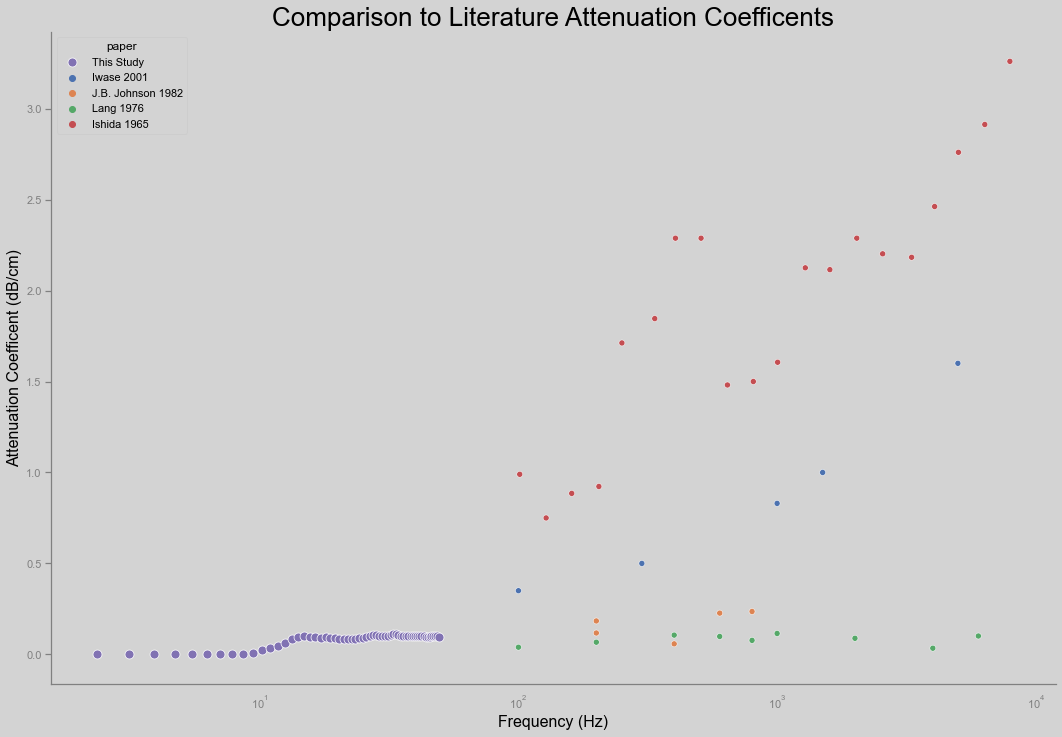

In [117]:
f, ax = plt.subplots()
sns.scatterplot(data = ourmean, label = 'This Study', color = 'C4', marker = 'o', s = 80)
sns.scatterplot(x = 'freq', y = 'attcoef', hue = 'paper', data = df, ax = ax)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Attenuation Coefficent (dB/cm)')
plt.title('Comparison to Literature Attenuation Coefficents')
plt.savefig('/Users/zachkeskinen/Documents/infrasound/figures/attenuation/ourtolit.png')